# Optimise on a btv dump and MWPC

In [1]:
import multiprocessing
import os 
from __future__ import print_function
import pybobyqa
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())
from IPython.display import display, clear_output

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

# Filter measurement

In [3]:
start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/small_df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [4]:
filenames

['df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle']

In [5]:
new_df = pd.DataFrame()
    
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df = pickle.load(handle)
        print(filenames[i])
    new_df = pd.concat([new_df,df])

df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle


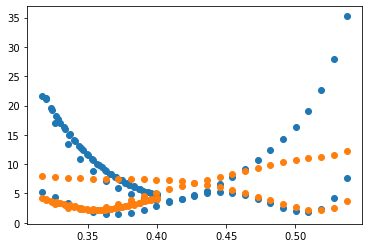

In [6]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01, new_df.sigH)
ax.scatter(new_df.k_qfn01, new_df.sigV)

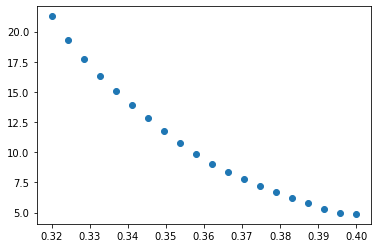

In [7]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[0:20], new_df.sigH[0:20])

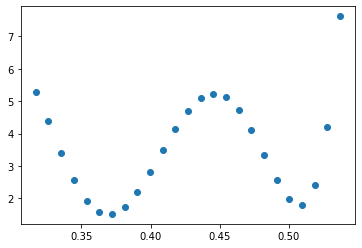

In [8]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[20:45], new_df.sigH[20:45])

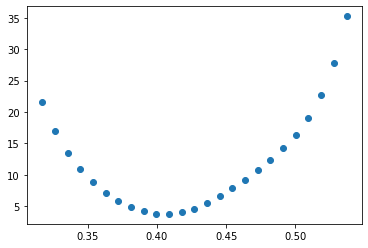

In [9]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[45:70], new_df.sigH[45:70])

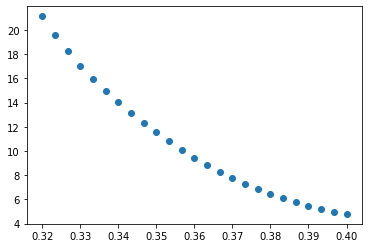

In [10]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[70:95], new_df.sigH[70:95])

### t8 data

In [11]:
start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/t8/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
filenames

with open(start_path+filenames[1], 'rb') as handle:
    df_t8 = pickle.load(handle)
    print(filenames[1])

df_quad_scan_t8_bpms_2022_07_27_17h01m48s.pickle


In [12]:
df_t8.head(2)

k_qfn01  k_qdn02  k_qfn03  k_qdn04  k_qfn05  k_qdn06   k_qdn07  k_qfn08  \
1  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.041224  0.06721   
2  0.47969 -0.17299  0.19864 -0.09035    0.196  -0.1946 -0.042449  0.06721   

        sigH       sigV  
1  11.960975  19.702300  
2  10.625982  18.179927

In [13]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df_t8)):

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df_t8.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df_t8.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df_t8.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df_t8.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df_t8.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df_t8.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df_t8.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df_t8.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

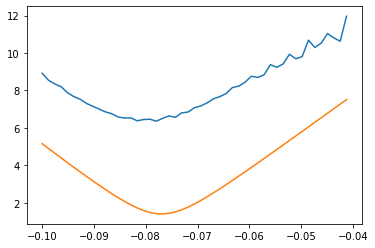

In [14]:
fig, ax = plt.subplots()
ax.plot(df_t8.k_qdn07, df_t8.sigH)
ax.plot(df_t8.k_qdn07, np.array(HSigma_madx)*1000)

# Optimize on a dataframe

In [15]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

# Optimise only in H and then in V all parameter

In [15]:
# Py-BOBYQA

#################################### Initialize MADX ####################################
madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

madxt8_1 = Madx()
madxt8_1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_1.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_1.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_1.input('FLATTEN;')
madxt8_1.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_1.input('FLATTEN;')
madxt8_1.input('ENDEDIT;')
madxt8_1.input("F62.BTV002 : MARKER;")
madxt8_1.input('SEQEDIT, sequence=f61t8_op;')
madxt8_1.input('FLATTEN;')
madxt8_1.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_1.input('FLATTEN;')
madxt8_1.input('ENDEDIT;')
madxt8_1.use(sequence="f61t8_op")

madxt8_2= Madx()
madxt8_2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_2.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_2.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_2.input('FLATTEN;')
madxt8_2.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_2.input('FLATTEN;')
madxt8_2.input('ENDEDIT;')
madxt8_2.input("F62.BTV002 : MARKER;")
madxt8_2.input('SEQEDIT, sequence=f61t8_op;')
madxt8_2.input('FLATTEN;')
madxt8_2.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_2.input('FLATTEN;')
madxt8_2.input('ENDEDIT;')
madxt8_2.use(sequence="f61t8_op")

madxt8_3= Madx()
madxt8_3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_3.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_3.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_3.input('FLATTEN;')
madxt8_3.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_3.input('FLATTEN;')
madxt8_3.input('ENDEDIT;')
madxt8_3.input("F62.BTV002 : MARKER;")
madxt8_3.input('SEQEDIT, sequence=f61t8_op;')
madxt8_3.input('FLATTEN;')
madxt8_3.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_3.input('FLATTEN;')
madxt8_3.input('ENDEDIT;')
madxt8_3.use(sequence="f61t8_op")

madxt8_4= Madx()
madxt8_4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_4.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_4.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_4.input('FLATTEN;')
madxt8_4.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_4.input('FLATTEN;')
madxt8_4.input('ENDEDIT;')
madxt8_4.input("F62.BTV002 : MARKER;")
madxt8_4.input('SEQEDIT, sequence=f61t8_op;')
madxt8_4.input('FLATTEN;')
madxt8_4.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_4.input('FLATTEN;')
madxt8_4.input('ENDEDIT;')
madxt8_4.use(sequence="f61t8_op")

btv= -6 #"f61.btv010"
instrument_focal_point = -13 #"t08.xwcm103"

dx0 = 0.13
dy0 = 0.0
dpx0 = 0.02
dpy0 = 0

bety0 = 33.2
alfy0 = 0.28
eyn = 1.5e-6
ey = eyn/(beta*gamma)

progress_obj = []
progress_params = []
iteration = 0
# Define the objective function
def f_fit(params):
    global progress_obj
    global iteration
    betx0, alfx0, dx0, dpx0, exn, sige = params
        
    ex = exn/(beta*gamma)

    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
        
    def worker1(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1
    
    def worker2(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1
    
    def worker3(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1
            
    def worker4(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        
        new_df["sigma_H_madx"]=madx_sigma_list
        
    # T8
    madxt8_1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

    def worker1_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_1.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_1.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_1.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_1.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_1.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_1.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_1.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_1.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1

    def worker2_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_2.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_2.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_2.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_2.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_2.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_2.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_2.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_2.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1

    def worker3_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_3.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_3.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_3.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_3.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_3.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_3.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_3.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_3.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1

    def worker4_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_4.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_4.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_4.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_4.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_4.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_4.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_4.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_4.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            i += 1

    if __name__ == "__main__":
            manager_t8 = multiprocessing.Manager()
            return_dict1 = manager_t8.dict()
            return_dict2 = manager_t8.dict()
            return_dict3 = manager_t8.dict()
            return_dict4 = manager_t8.dict()

            jobs = []
            p1 = multiprocessing.Process(target=worker1_t8, args=(np.array_split(df_t8, 4)[0], return_dict1))
            p2 = multiprocessing.Process(target=worker2_t8, args=(np.array_split(df_t8, 4)[1], return_dict2))
            p3 = multiprocessing.Process(target=worker3_t8, args=(np.array_split(df_t8, 4)[2], return_dict3))
            p4 = multiprocessing.Process(target=worker4_t8, args=(np.array_split(df_t8, 4)[3], return_dict4))

            p1.start()
            p2.start()
            p3.start()
            p4.start()

            p1.join()
            p2.join()
            p3.join()
            p4.join()

            madx_sigma_list = []
            madx_sigma_list.extend(return_dict1.values())
            madx_sigma_list.extend(return_dict2.values())
            madx_sigma_list.extend(return_dict3.values())
            madx_sigma_list.extend(return_dict4.values())

            df_t8["sigma_H_madx"]=madx_sigma_list
    
    t8_objective = (df_t8["sigma_H_madx"]-df_t8["sigH"])**2

    objective = 2*sum(abs(t8_objective)) + 1*sum(abs(new_df["sigma_H_madx"]-new_df["sigH"])**2)

    clear_output(wait=True)
    display('Iteration: '+str(iteration)+'/'+str(maxfun),'Params '+str(params),'Objective '+str(objective))
#     progress_obj.append(objective)
#     progress_params.append(params)
    
#     with open('progress_H.pickle', 'wb') as handle:
#         pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open('params_H.pickle', 'wb') as handle:
#         pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    iteration +=1
    return (objective)
       
initial_guess = [154, -36.9, 0.13, 0.02, 7.64e-6, 6.79e-4]

# Define bound constraints (lower <= x <= upper)
lower = np.array([80, -40, 0.0, 0.0, 0.0, 0.0])
upper = np.array([160, -25, 2.0, 1.0, 5.0e-5, 1.0e-2])

# Call Py-BOBYQA (with bounds)
maxfun = 1000
solnH = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=True, scaling_within_bounds=True, rhoend=1e-4, maxfun=maxfun)

# Display output
print(solnH)

KeyboardInterrupt: 

In [ ]:
solnH.x

In [ ]:
betx0 = solnH.x[0]
alfx0 = solnH.x[1]
dx0 = solnH.x[2]
dpx0 = solnH.x[3]
exn = solnH.x[4]
sige = solnH.x[5]

dy0 = 0.0
dpy0 = 0

bety0 = 5.2
alfy0 = 0.25
eyn = 3.53e-6

In [ ]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for i in range(len(new_df)):
    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=Dy0, Dpx=dpx0, Dpy=Dpy0).dframe()

  

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

ax[0].scatter(new_df.k_qfn01, new_df.sigH, color="magenta", linewidth=2, marker="x", label="Acq 3", zorder=99)
ax[1].scatter(new_df.k_qfn01, new_df.sigV, color="tomato", linewidth=2, marker="x", label="Acq 3", zorder=99)

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")


# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(Dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(Dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

In [ ]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df_t8)):

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df_t8.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df_t8.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df_t8.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df_t8.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df_t8.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df_t8.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df_t8.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df_t8.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=Dy0, Dpx=dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(df_t8.k_qdn07, df_t8.sigH, marker="x", ls="")
ax[0].plot(df_t8.k_qdn07, np.array(HSigma_madx)*1000)
ax[1].plot(df_t8.k_qdn07, df_t8.sigV, marker="x", ls="")
ax[1].plot(df_t8.k_qdn07, np.array(VSigma_madx)*1000)

# Optimise in V using previous result in the H plane

In [26]:
# Py-BOBYQA

#################################### Initialize MADX ####################################
madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

madxt8_1 = Madx()
madxt8_1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_1.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_1.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_1.input('FLATTEN;')
madxt8_1.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_1.input('FLATTEN;')
madxt8_1.input('ENDEDIT;')
madxt8_1.input("F62.BTV002 : MARKER;")
madxt8_1.input('SEQEDIT, sequence=f61t8_op;')
madxt8_1.input('FLATTEN;')
madxt8_1.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_1.input('FLATTEN;')
madxt8_1.input('ENDEDIT;')
madxt8_1.use(sequence="f61t8_op")

madxt8_2= Madx()
madxt8_2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_2.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_2.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_2.input('FLATTEN;')
madxt8_2.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_2.input('FLATTEN;')
madxt8_2.input('ENDEDIT;')
madxt8_2.input("F62.BTV002 : MARKER;")
madxt8_2.input('SEQEDIT, sequence=f61t8_op;')
madxt8_2.input('FLATTEN;')
madxt8_2.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_2.input('FLATTEN;')
madxt8_2.input('ENDEDIT;')
madxt8_2.use(sequence="f61t8_op")

madxt8_3= Madx()
madxt8_3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_3.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_3.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_3.input('FLATTEN;')
madxt8_3.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_3.input('FLATTEN;')
madxt8_3.input('ENDEDIT;')
madxt8_3.input("F62.BTV002 : MARKER;")
madxt8_3.input('SEQEDIT, sequence=f61t8_op;')
madxt8_3.input('FLATTEN;')
madxt8_3.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_3.input('FLATTEN;')
madxt8_3.input('ENDEDIT;')
madxt8_3.use(sequence="f61t8_op")

madxt8_4= Madx()
madxt8_4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_4.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_4.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_4.input('FLATTEN;')
madxt8_4.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_4.input('FLATTEN;')
madxt8_4.input('ENDEDIT;')
madxt8_4.input("F62.BTV002 : MARKER;")
madxt8_4.input('SEQEDIT, sequence=f61t8_op;')
madxt8_4.input('FLATTEN;')
madxt8_4.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_4.input('FLATTEN;')
madxt8_4.input('ENDEDIT;')
madxt8_4.use(sequence="f61t8_op")

btv= -6 #"f61.btv010"
instrument_focal_point = -13 #"t08.xwcm103"

betx0 = solnH.x[0]
alfx0 = solnH.x[1]
dx0 = solnH.x[2]
dpx0 = solnH.x[3]
exn = solnH.x[4]
sige = solnH.x[5]

dy0 = 0.0
dpy0 = 0

ex = exn/(beta*gamma)

progress_obj = []
progress_params = []
iteration = 1
# Define the objective function
def f_fit(params):
    global progress_obj
    global iteration

    bety0, alfy0, dy0, dpy0, eyn = params
    ey = eyn/(beta*gamma)
    
    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
        
    def worker1(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1
    
    def worker2(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = (beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1
    
    def worker3(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1
            
    def worker4(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        
        new_df["sigma_V_madx"]=madx_sigma_list
        
    # T8
    madxt8_1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

    def worker1_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_1.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_1.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_1.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_1.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_1.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_1.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_1.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_1.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1

    def worker2_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_2.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_2.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_2.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_2.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_2.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_2.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_2.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_2.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1

    def worker3_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_3.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_3.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_3.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_3.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_3.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_3.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_3.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_3.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1

    def worker4_t8(df, return_dict):
        i = 0
        for idx in list(df.index.values):
            madxt8_4.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_4.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_4.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_4.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_4.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_4.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_4.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_4.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = V_sigma_madx
            i += 1

    if __name__ == "__main__":
            manager_t8 = multiprocessing.Manager()
            return_dict1 = manager_t8.dict()
            return_dict2 = manager_t8.dict()
            return_dict3 = manager_t8.dict()
            return_dict4 = manager_t8.dict()

            jobs = []
            p1 = multiprocessing.Process(target=worker1_t8, args=(np.array_split(df_t8, 4)[0], return_dict1))
            p2 = multiprocessing.Process(target=worker2_t8, args=(np.array_split(df_t8, 4)[1], return_dict2))
            p3 = multiprocessing.Process(target=worker3_t8, args=(np.array_split(df_t8, 4)[2], return_dict3))
            p4 = multiprocessing.Process(target=worker4_t8, args=(np.array_split(df_t8, 4)[3], return_dict4))

            p1.start()
            p2.start()
            p3.start()
            p4.start()

            p1.join()
            p2.join()
            p3.join()
            p4.join()

            madx_sigma_list = []
            madx_sigma_list.extend(return_dict1.values())
            madx_sigma_list.extend(return_dict2.values())
            madx_sigma_list.extend(return_dict3.values())
            madx_sigma_list.extend(return_dict4.values())

            df_t8["sigma_V_madx"]=madx_sigma_list
    
    t8_objective = (df_t8["sigma_V_madx"]-df_t8["sigV"])**2

    objective = 2*sum(abs(t8_objective)) + 1*sum(abs(new_df["sigma_V_madx"]-new_df["sigV"])**2)

    clear_output(wait=True)
    display('Iteration: '+str(iteration)+'/'+str(maxfun),'Params '+str(params),'Objective '+str(objective))
#     progress_obj.append(objective)
#     progress_params.append(params)
    
#     with open('progress_H.pickle', 'wb') as handle:
#         pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open('params_H.pickle', 'wb') as handle:
#         pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    iteration +=1
    return (objective)
       
initial_guess = [4.95, 0.017, 0.0, 0.0, 1.2e-6]

# Define bound constraints (lower <= x <= upper)
lower = np.array([3, -50, -1.0, -1.0, 0.0])
upper = np.array([10, 50, 1.0, 1.0, 5.0e-5])

# Call Py-BOBYQA (with bounds)
maxfun = 10000
solnV = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=True, scaling_within_bounds=True, rhoend=1e-4, maxfun=maxfun)

# Display output
print(solnV)

'Iteration: 6065/10000'

'Params [  3.98151772 -13.98488358  -0.04393717   0.04983384   0.        ]'

'Objective 1729.7167228341657'

****** Py-BOBYQA Results ******
Solution xmin = [ 7.57562479e+00  3.81603134e+00 -1.61321923e-01  5.93777833e-03
  7.98482038e-07]
Objective value f(xmin) = 744.8958846
Needed 6065 objective evaluations (at 6065 points)
Did a total of 47 runs
Approximate gradient = [-6.05042895e+01  6.93570149e+00  1.56611484e+02 -1.90856739e+02
 -1.32519102e+07]
Approximate Hessian = [[ 2.10008838e+05  5.85723479e+03  4.03722085e+05 -1.69629904e+05
   2.51169105e+10]
 [ 5.85723479e+03  1.04702304e+03  6.23321063e+03 -4.46739250e+04
  -9.79210092e+08]
 [ 4.03722085e+05  6.23321063e+03  5.84661882e+05  1.08926421e+05
  -2.46487486e+10]
 [-1.69629904e+05 -4.46739250e+04  1.08926421e+05  6.36900201e+06
   2.27647472e+11]
 [ 2.51169105e+10 -9.79210092e+08 -2.46487486e+10  2.27647472e+11
   1.25773756e+16]]
Exit flag = 0
Success: Reached maximum total number of unsuccessful restarts
******************************



In [27]:
# New initial conditions
bety0 = solnV.x[0]
alfy0 = solnV.x[1]
dy0 = solnV.x[2]
dpy0 = solnV.x[3]
eyn = solnV.x[4]
print (betx0, bety0, alfx0, alfy0, dx0, dpx0, dy0, dpy0, exn, eyn, sige)

148.04699946152772 7.575624789879866 -35.89222698029671 3.8160313449356877 0.3489592233357992 0.07305711885121609 -0.16132192322605876 0.005937778333989785 7.617396981118602e-06 7.984820379535744e-07 0.006481300460693186


Text(0.7, 0.8, 'Matched initial parameters:\n$\\beta_{x}$=148.047\n$\\beta_{y}$=7.576\n$\\alpha_{x}$=-35.892\n$\\alpha_{y}$=3.816\n$D_{x}$=0.349\n$D_{y}$=-0.161\n$D_{px}$=0.073\n$D_{py}$=0.006\n$exn$=7.62e-06\n$eyn$=8e-07\n$\\frac{dp}{p}$=0.006481')

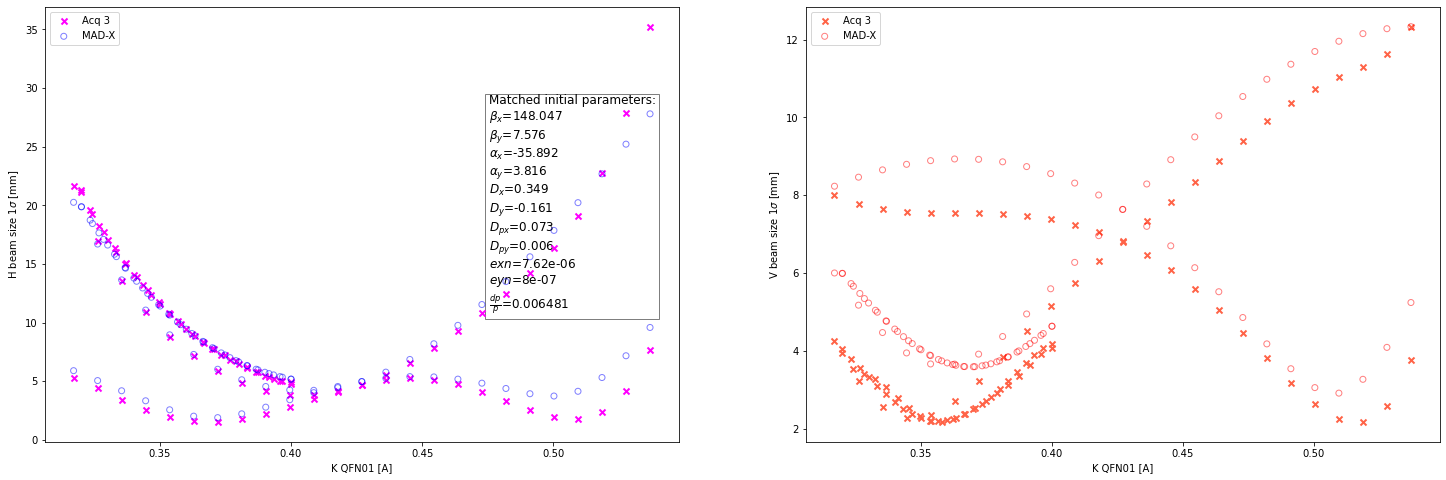

In [28]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for i in range(len(new_df)):
    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

  
    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

ax[0].scatter(new_df.k_qfn01, new_df.sigH, color="magenta", linewidth=2, marker="x", label="Acq 3", zorder=99)
ax[1].scatter(new_df.k_qfn01, new_df.sigV, color="tomato", linewidth=2, marker="x", label="Acq 3", zorder=99)

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")


# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

Text(0.5, 0, 'K QDN07')

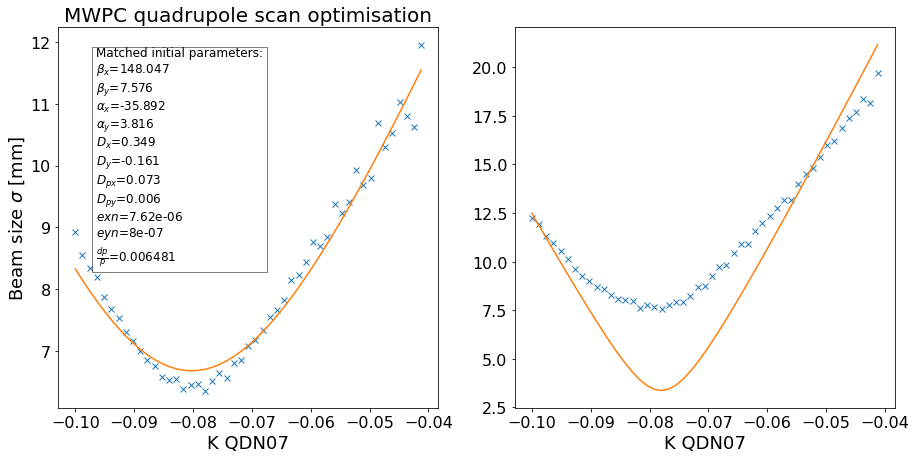

In [29]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df_t8)):

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df_t8.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df_t8.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df_t8.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df_t8.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df_t8.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df_t8.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df_t8.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df_t8.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(df_t8.k_qdn07, df_t8.sigH, marker="x", ls="")
ax[0].plot(df_t8.k_qdn07, np.array(HSigma_madx)*1000)
ax[1].plot(df_t8.k_qdn07, df_t8.sigV, marker="x", ls="")
ax[1].plot(df_t8.k_qdn07, np.array(VSigma_madx)*1000)

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)
# place a text box in upper left in axes coords
ax[0].text(0.1, 0.95, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax[0].set_xlabel("K QDN07", fontsize=18)
ax[0].set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[0].set_title(f"MWPC quadrupole scan optimisation", fontsize=20)
ax[1].set_xlabel("K QDN07", fontsize=18)
# plt.savefig("fig/mwpc_quad_scan_optimisation.png", dpi=300, format=None, metadata=None,
#         bbox_inches="tight", transparent = False)

# Optimise both planes in one go

In [17]:
# Py-BOBYQA

#################################### Initialize MADX ####################################
madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

madxt8_1 = Madx()
madxt8_1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_1.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_1.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_1.input('FLATTEN;')
madxt8_1.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_1.input('FLATTEN;')
madxt8_1.input('ENDEDIT;')
madxt8_1.input("F62.BTV002 : MARKER;")
madxt8_1.input('SEQEDIT, sequence=f61t8_op;')
madxt8_1.input('FLATTEN;')
madxt8_1.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_1.input('FLATTEN;')
madxt8_1.input('ENDEDIT;')
madxt8_1.use(sequence="f61t8_op")

madxt8_2= Madx()
madxt8_2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_2.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_2.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_2.input('FLATTEN;')
madxt8_2.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_2.input('FLATTEN;')
madxt8_2.input('ENDEDIT;')
madxt8_2.input("F62.BTV002 : MARKER;")
madxt8_2.input('SEQEDIT, sequence=f61t8_op;')
madxt8_2.input('FLATTEN;')
madxt8_2.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_2.input('FLATTEN;')
madxt8_2.input('ENDEDIT;')
madxt8_2.use(sequence="f61t8_op")

madxt8_3= Madx()
madxt8_3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_3.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_3.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_3.input('FLATTEN;')
madxt8_3.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_3.input('FLATTEN;')
madxt8_3.input('ENDEDIT;')
madxt8_3.input("F62.BTV002 : MARKER;")
madxt8_3.input('SEQEDIT, sequence=f61t8_op;')
madxt8_3.input('FLATTEN;')
madxt8_3.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_3.input('FLATTEN;')
madxt8_3.input('ENDEDIT;')
madxt8_3.use(sequence="f61t8_op")

madxt8_4= Madx()
madxt8_4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madxt8_4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")
madxt8_4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madxt8_4.input('BRHO      := BEAM->PC * 3.3356;')
madxt8_4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madxt8_4.input('SEQEDIT, SEQUENCE=f61t8_op;')
madxt8_4.input('FLATTEN;')
madxt8_4.input('REMOVE, ELEMENT=ARBMATRIX;')
madxt8_4.input('FLATTEN;')
madxt8_4.input('ENDEDIT;')
madxt8_4.input("F62.BTV002 : MARKER;")
madxt8_4.input('SEQEDIT, sequence=f61t8_op;')
madxt8_4.input('FLATTEN;')
madxt8_4.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madxt8_4.input('FLATTEN;')
madxt8_4.input('ENDEDIT;')
madxt8_4.use(sequence="f61t8_op")

btv= -6 #"f61.btv010"
instrument_focal_point = -13 #"t08.xwcm103"

progress_obj = []
progress_params = []
iteration = 0
# Define the objective function
def f_fit(params):
    global progress_obj
    global iteration
    betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params
        
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
        
    def worker1(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker2(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker3(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
            
    def worker4(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")
            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1, return_dict1V))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2, return_dict2V))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3, return_dict3V))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4, return_dict4V))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        new_df["sigma_H_madx"]=madx_sigma_list
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1V.values())
        madx_sigma_list.extend(return_dict2V.values())
        madx_sigma_list.extend(return_dict3V.values())
        madx_sigma_list.extend(return_dict4V.values())
        new_df["sigma_V_madx"]=madx_sigma_list
        
    # T8
    madxt8_1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madxt8_4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

    def worker1_t8(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            madxt8_1.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_1.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_1.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_1.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_1.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_1.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_1.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_1.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1

    def worker2_t8(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            madxt8_2.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_2.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_2.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_2.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_2.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_2.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_2.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_2.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1

    def worker3_t8(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            madxt8_3.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_3.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_3.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_3.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_3.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_3.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_3.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_3.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1

    def worker4_t8(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            madxt8_4.input("kQFN1 = "+str(df_t8.k_qfn01[idx])+";")
            madxt8_4.input("kQDN2 = "+str(df_t8.k_qdn02[idx])+";")
            madxt8_4.input("kQFN3 = "+str(df_t8.k_qfn03[idx])+";")
            madxt8_4.input("kQDN4 = "+str(df_t8.k_qdn04[idx])+";")
            madxt8_4.input("kQFN5 = "+str(df_t8.k_qfn05[idx])+";")
            madxt8_4.input("kQDN6 = "+str(df_t8.k_qdn06[idx])+";")
            madxt8_4.input("kQDN7 = "+str(df_t8.k_qdn07[idx])+";")
            madxt8_4.input("kQFN8 = "+str(df_t8.k_qfn08[idx])+";")
            twiss_f61d = madxt8_4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
            H_sigma_madx = ( beam_size(twiss_f61d['betx'][instrument_focal_point], twiss_f61d['dx'][instrument_focal_point], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][instrument_focal_point], twiss_f61d['dy'][instrument_focal_point], ey, sige, 1) )*1000
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1

    if __name__ == "__main__":
            manager_t8 = multiprocessing.Manager()
            return_dict1 = manager_t8.dict()
            return_dict2 = manager_t8.dict()
            return_dict3 = manager_t8.dict()
            return_dict4 = manager_t8.dict()
            return_dict1V = manager_t8.dict()
            return_dict2V = manager_t8.dict()
            return_dict3V = manager_t8.dict()
            return_dict4V = manager_t8.dict()

            jobs = []
            p1 = multiprocessing.Process(target=worker1_t8, args=(np.array_split(df_t8, 4)[0], return_dict1, return_dict1V))
            p2 = multiprocessing.Process(target=worker2_t8, args=(np.array_split(df_t8, 4)[1], return_dict2, return_dict2V))
            p3 = multiprocessing.Process(target=worker3_t8, args=(np.array_split(df_t8, 4)[2], return_dict3, return_dict3V))
            p4 = multiprocessing.Process(target=worker4_t8, args=(np.array_split(df_t8, 4)[3], return_dict4, return_dict4V))

            p1.start()
            p2.start()
            p3.start()
            p4.start()

            p1.join()
            p2.join()
            p3.join()
            p4.join()

            madx_sigma_list = []
            madx_sigma_list.extend(return_dict1.values())
            madx_sigma_list.extend(return_dict2.values())
            madx_sigma_list.extend(return_dict3.values())
            madx_sigma_list.extend(return_dict4.values())
            df_t8["sigma_H_madx"]=madx_sigma_list
            
            madx_sigma_list = []
            madx_sigma_list.extend(return_dict1V.values())
            madx_sigma_list.extend(return_dict2V.values())
            madx_sigma_list.extend(return_dict3V.values())
            madx_sigma_list.extend(return_dict4V.values())
            df_t8["sigma_V_madx"]=madx_sigma_list
    
    t8_objective = 1*sum((abs(df_t8["sigma_H_madx"]-df_t8["sigH"]))**2) + 1*sum((abs(df_t8["sigma_V_madx"]-df_t8["sigV"]))**2)
    east_dump_objective = 1*sum(abs(new_df["sigma_H_madx"]-new_df["sigH"])**2) + 1*sum(abs(new_df["sigma_V_madx"]-new_df["sigV"])**2)
    
    objective = 2*t8_objective + 1*east_dump_objective

    clear_output(wait=True)
    display('Iteration: '+str(iteration)+'/'+str(maxfun),'Params '+str(params),'Objective '+str(objective))
#     progress_obj.append(objective)
#     progress_params.append(params)
    
#     with open('progress_H.pickle', 'wb') as handle:
#         pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open('params_H.pickle', 'wb') as handle:
#         pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    iteration +=1
    return (objective)

#              betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn,    eyn,    sige
initial_guess = [154, 4.95, -36.9, 0.017, 0.13, 0.0, 0.02, 0.0, 7.64e-6, 1.2e-6, 6.79e-4]

# Define bound constraints (lower <= x <= upper)
lower = np.array([10, 1, -50, -50,  -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0])
upper = np.array([200, 20, 50, 50, 1.0, 1.0, 1.0, 1.0, 5.0e-5, 5.0e-5, 1.0e-2])

# Call Py-BOBYQA (with bounds)
maxfun = 50000
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=True, scaling_within_bounds=True, rhoend=1e-8, maxfun=maxfun)

# Display output
print(soln)

'Iteration: 49999/50000'

'Params [ 1.01299178e+01  1.97456195e+01  4.34675099e+01 -4.97474936e+01\n -8.40834851e-01 -4.00793990e-01  7.03833494e-02  7.23673948e-01\n  6.53274784e-09  4.85445841e-11  4.46626489e-04]'

'Objective 10772.654015192657'

****** Py-BOBYQA Results ******
Solution xmin = [ 1.35404981e+02  8.13879634e+00 -3.30184109e+01 -4.69059882e+00
  5.57635693e-01 -1.89696948e-01  1.20750623e-01  3.19447311e-02
  7.82942972e-06  2.74401259e-07  5.88246591e-03]
Objective value f(xmin) = 1076.659477
Needed 50000 objective evaluations (at 50000 points)
Did a total of 7 runs
Approximate gradient = [-5.72135709e-06 -1.93228077e-05 -4.93412622e-05 -5.74283444e-06
  7.18465304e-04 -4.78011028e-04 -1.61986826e-03  8.72042588e-04
  9.12985661e+01  8.29402161e+01  6.65627395e-02]
Approximate Hessian = [[ 1.34432795e+01 -3.17985549e-01  5.65367663e+01 -1.54015426e-01
  -6.90992015e+02 -2.23382334e+01  2.92194071e+03 -8.38251103e+00
  -8.79643667e+06 -1.31272399e+06 -2.08893209e+04]
 [-3.17985549e-01  2.92505211e+01 -3.54847478e+00  3.96331141e+01
   5.55844372e+01  5.06134097e+02 -6.07172946e+01 -4.32134259e+03
   1.16512455e+07 -4.10954379e+08 -3.66005709e+04]
 [ 5.65367663e+01 -3.54847478e+00  2.42719361e+02 -5.21528255e-01
  

In [18]:
soln.x

array([ 1.35404981e+02,  8.13879634e+00, -3.30184109e+01, -4.69059882e+00,
        5.57635693e-01, -1.89696948e-01,  1.20750623e-01,  3.19447311e-02,
        7.82942972e-06,  2.74401259e-07,  5.88246591e-03])

In [19]:
betx0 = soln.x[0]
bety0 = soln.x[1]
alfx0 = soln.x[2]
alfy0 = soln.x[3]
dx0 = soln.x[4]
dy0 = soln.x[5]
dpx0 = soln.x[6]
dpy0 = soln.x[7]
exn = soln.x[8]
eyn = soln.x[9]
sige = soln.x[10]

In [20]:
print (betx0, bety0, alfx0, alfy0, dx0, dpx0, dy0, dpy0, exn, eyn, sige)

135.4049813917612 8.138796342516862 -33.01841092200931 -4.690598822115497 0.5576356932824436 0.12075062264051106 -0.18969694838822282 0.03194473107040463 7.829429723828345e-06 2.7440125928902435e-07 0.005882465906014055


Text(0.7, 0.8, 'Matched initial parameters:\n$\\beta_{x}$=135.405\n$\\beta_{y}$=8.139\n$\\alpha_{x}$=-33.018\n$\\alpha_{y}$=-4.691\n$D_{x}$=0.558\n$D_{y}$=-0.19\n$D_{px}$=0.121\n$D_{py}$=0.032\n$exn$=7.83e-06\n$eyn$=2.7e-07\n$\\frac{dp}{p}$=0.005882')

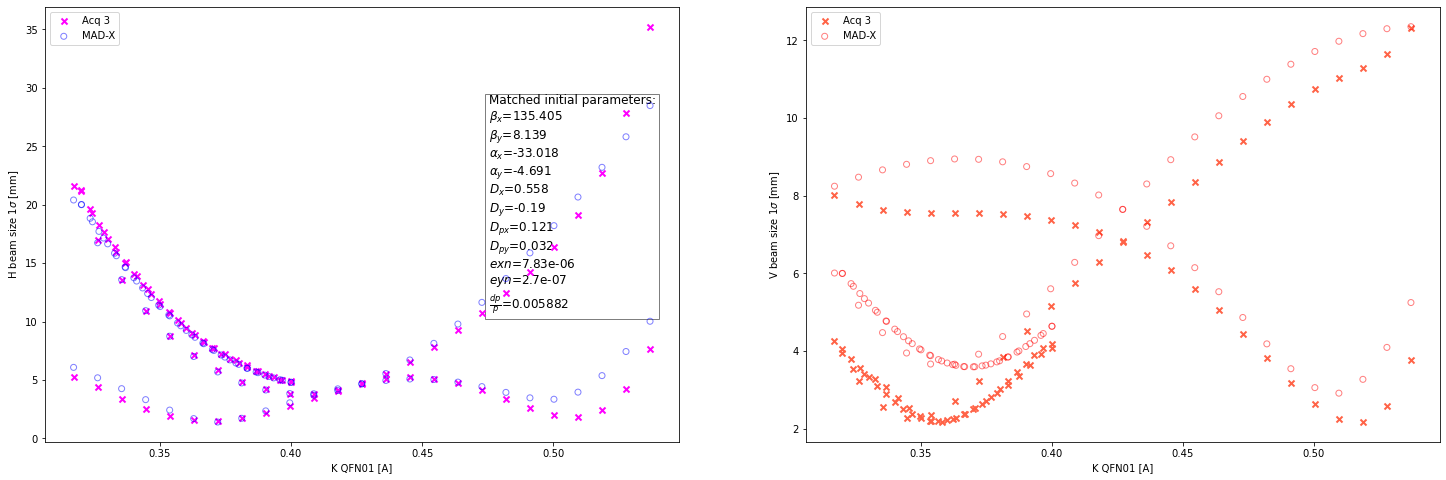

In [21]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for i in range(len(new_df)):
    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

  
    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

ax[0].scatter(new_df.k_qfn01, new_df.sigH, color="magenta", linewidth=2, marker="x", label="Acq 3", zorder=99)
ax[1].scatter(new_df.k_qfn01, new_df.sigV, color="tomato", linewidth=2, marker="x", label="Acq 3", zorder=99)

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")


# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

Text(0.5, 0, 'K QDN07')

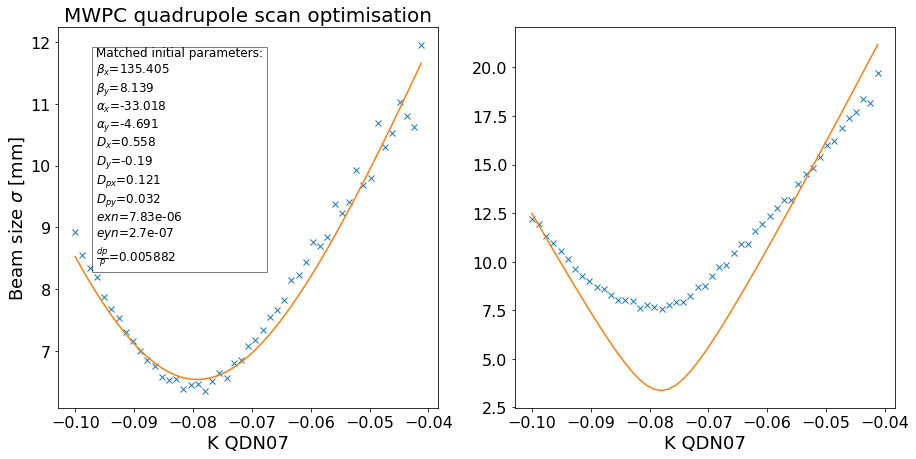

In [22]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df_t8)):

    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df_t8.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df_t8.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df_t8.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df_t8.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df_t8.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df_t8.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df_t8.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df_t8.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(df_t8.k_qdn07, df_t8.sigH, marker="x", ls="")
ax[0].plot(df_t8.k_qdn07, np.array(HSigma_madx)*1000)
ax[1].plot(df_t8.k_qdn07, df_t8.sigV, marker="x", ls="")
ax[1].plot(df_t8.k_qdn07, np.array(VSigma_madx)*1000)

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)
# place a text box in upper left in axes coords
ax[0].text(0.1, 0.95, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax[0].set_xlabel("K QDN07", fontsize=18)
ax[0].set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[0].set_title(f"MWPC quadrupole scan optimisation", fontsize=20)
ax[1].set_xlabel("K QDN07", fontsize=18)
# plt.savefig("fig/mwpc_quad_scan_optimisation.png", dpi=300, format=None, metadata=None,
#         bbox_inches="tight", transparent = False)